In [ ]:
"""
CS895_Computational_Imaging_Spring_2025__
|
DNA_DAMAGE_QUANTIFICATION (DDQ)
CS895_CI_ddq_custom_model_training.ipynb
Created on Tue Feb 25 18:23:59 2025
@authors: Rochana Obadage and Kumushini Thennakoon
|
Referenced from: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb
"""


# cellpose 3.1

We will first install cellpose 3.1, check the GPU is working, and mount google drive to get your models and images.

## Installation

In [22]:
!pip install numpy==1.26.4

In [20]:
!pip install numpy==1.26.4
!pip uninstall -y cellpose

Found existing installation: cellpose 3.1.1
Uninstalling cellpose-3.1.1:
  Successfully uninstalled cellpose-3.1.1
Found existing installation: cellpose 3.1.1
Uninstalling cellpose-3.1.1:
  Successfully uninstalled cellpose-3.1.1


In [60]:
!pip install "opencv-python-headless<4.3"
!pip install "cellpose==3.1.1"

`Check CUDA version and that GPU is working in cellpose and import other libraries.`

In [24]:
# !nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

from natsort import natsorted

# import matplotlib.pyplot as plt
# import numpy as np
# from skimage import io


use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

Tue Sep 30 12:44:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8             13W /  285W |    3517MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
# Update paths to match your actual folder structure
train_files = natsorted(glob('train/*.tif'))
train_seg = natsorted(glob('train/*_seg.npy'))

test_files = natsorted(glob('test/*.tif'))
test_seg = natsorted(glob('test/*_seg.npy'))

# Print the files found to verify paths
print("Training files found:")
for f in train_files:
    print(f"  {f}")
    
print("\nTraining segmentation files found:")
for f in train_seg:
    print(f"  {f}")
    
print("\nTest files found:")
for f in test_files:
    print(f"  {f}")
    
print("\nTest segmentation files found:")
for f in test_seg:
    print(f"  {f}")

Training files found:
  train/4Gy_53BP1_1Hr.tif
  train/4Gy_53BP1_4Hr.tif
  train/4Gy_gH2AX_1Hr.tif
  train/4Gy_gH2AX_4Hr.tif
  train/8Gy_53BP1_1Hr.tif
  train/8Gy_53BP1_4Hr.tif
  train/8Gy_gH2AX_1Hr.tif

Training segmentation files found:
  train/4Gy_53BP1_1Hr_seg.npy
  train/4Gy_53BP1_4Hr_seg.npy
  train/4Gy_gH2AX_1Hr_seg.npy
  train/4Gy_gH2AX_4Hr_seg.npy
  train/8Gy_53BP1_1Hr_seg.npy
  train/8Gy_53BP1_4Hr_seg.npy
  train/8Gy_gH2AX_1Hr_seg.npy

Test files found:
  test/4Gy_53BP1_8Hr.tif
  test/4Gy_gH2AX_8Hr.tif
  test/8Gy_53BP1_8Hr.tif
  test/8Gy_gH2AX_8Hr.tif

Test segmentation files found:
  test/4Gy_53BP1_8Hr_seg.npy
  test/4Gy_gH2AX_8Hr_seg.npy
  test/8Gy_53BP1_8Hr_seg.npy
  test/8Gy_gH2AX_8Hr_seg.npy


`what the training images look like + their labels`

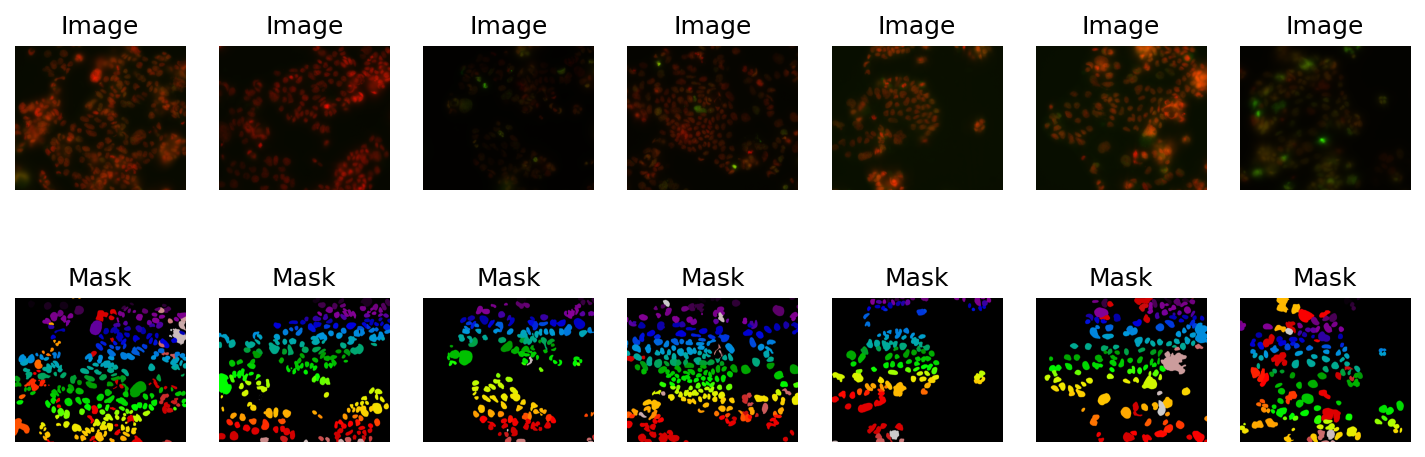

In [26]:
# %matplotlib inline
plt.figure(figsize=(12, 4), dpi=150)

for k, f in enumerate(train_files):
    # Load image
    img = io.imread(f)

    # Normalize image if needed
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # scale to [0, 1]

    # Plot image
    plt.subplot(2, len(train_files), k + 1)
    img = np.vstack((img, np.zeros_like(img)[:1]))  # Optional: remove if not needed
    img = img.transpose(1, 2, 0) if img.ndim == 3 else img
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")

    # Load and plot mask
    plt.subplot(2, len(train_files), len(train_files) + k + 1)
    seg_path = os.path.splitext(f)[0] + '_seg.npy'
    seg = np.load(seg_path, allow_pickle=True).item()
    masks = seg['masks'].squeeze()
    plt.imshow(masks, cmap='nipy_spectral')  # color-coded mask
    plt.axis('off')
    plt.title("Mask")


# Train model on manual annotations

## Training parameters

<font size = 2> **Paths for training, predictions and results**


<font size = 2>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images).

<font size = 2>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 2>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 2>**Training parameters**

<font size = 2>**`number_of_epochs`:** Input how many epochs the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [82]:
train_dir = "train" 
test_dir = "test" 

#Define where the patch file will be saved
base = "cellpose"

# model name and path
from cellpose import models
initial_model = "nuclei" # ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "ddq_model_1"

# other parameters for training.
n_epochs =  100
Channel_to_use_for_training = "Red" # ["Grayscale", "Blue", "Green", "Red"]

# If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

# Advanced Parameters
Use_Default_Advanced_Parameters = True
learning_rate = 0.1 
weight_decay = 0.0001 

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = 'custom_models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [15]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)

python -m cellpose --use_gpu --verbose --train --dir dataset/train --pretrained_model nuclei --chan 1 --chan2 0 --n_epochs 100 --learning_rate 0.1 --weight_decay 0.0001 --test_dir dataset/test --mask_filter _seg.npy


## Train new model

Using settings from form above, train model in notebook.

In [ ]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# Create model directory if it doesn't exist
os.makedirs(model_path, exist_ok=True)
print(f"Model save path: {model_path}")

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=model_path,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2025-09-30 14:45:06,257 [INFO] WRITING LOG OUTPUT TO /home/cse/.cellpose/run.log
2025-09-30 14:45:06,258 [INFO] 
cellpose version: 	3.1.1 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0+cu128
2025-09-30 14:45:06,260 [INFO] >> nuclei << model set to be used
2025-09-30 14:45:06,258 [INFO] 
cellpose version: 	3.1.1 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0+cu128
2025-09-30 14:45:06,260 [INFO] >> nuclei << model set to be used
2025-09-30 14:45:06,279 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 14:45:06,280 [INFO] >>>> using GPU (CUDA)
2025-09-30 14:45:06,279 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 14:45:06,280 [INFO] >>>> using GPU (CUDA)
2025-09-30 14:45:06,304 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 14:45:06,304 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 14:45:06,329 [INFO] >>>> model diam_mean =  17.000 (ROIs res

100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

2025-09-30 14:45:18,218 [INFO] >>> computing diameters



100%|██████████| 7/7 [00:00<00:00, 93.11it/s]

2025-09-30 14:45:18,294 [INFO] >>> using channels [1, 0]
2025-09-30 14:45:18,295 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2025-09-30 14:45:18,295 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-09-30 14:45:18,882 [INFO] >>> n_epochs=100, n_train=7, n_test=None
2025-09-30 14:45:18,883 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2025-09-30 14:45:18,883 [INFO] >>> saving model to custom_models/models/ddq_model_1
2025-09-30 14:45:18,883 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2025-09-30 14:45:18,883 [INFO] >>> saving model to custom_models/models/ddq_model_1
2025-09-30 14:45:19,227 [INFO] 0, train_loss=0.3903, test_loss=0.0000, LR=0.000000, time 0.34s
2025-09-30 14:45:19,227 [INFO] 0, train_loss=0.3903, test_loss=0.0000, LR=0.000000, time 0.34s
2025-09-30 14:45:20,582 [INFO] 5, train_loss=0.4473, test_loss=0.0000, LR=0.055556, time 1.70s
2025-09-30 14:45:20,582 [INFO] 5, train_loss=0.4473, test_loss=0.0000, LR=0.055556, time 1.70s
2025-09-30 14:45:21,959 [INFO] 10, train_loss=0.3448, test_loss=0.0000, LR=0.100000, time 3.08s
2025-09-30 14:45:21,959 [INFO] 10, train_loss=0.3448, test_loss=0.0000, LR=0.100000,

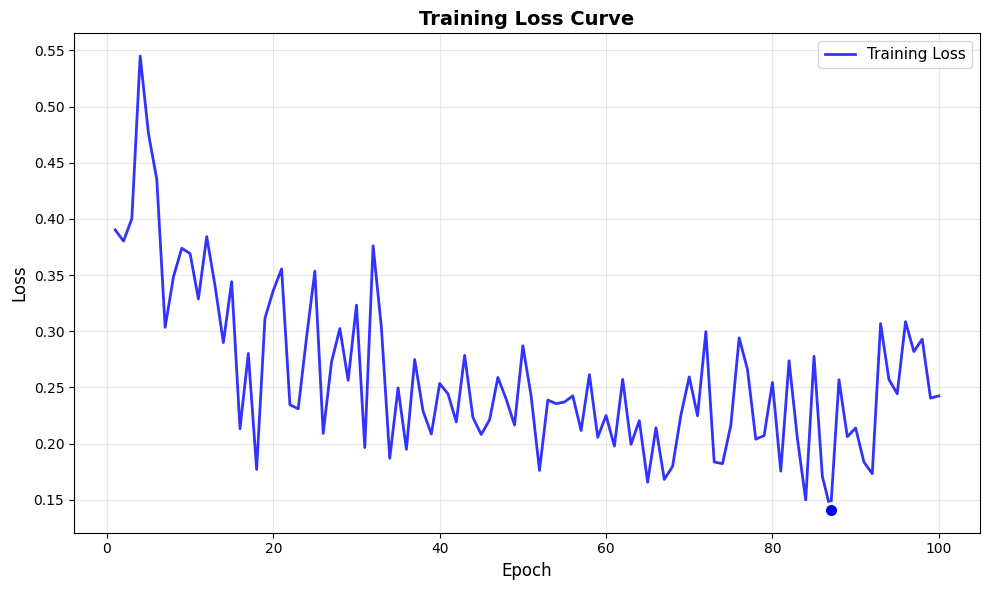

 TRAINING PERFORMANCE ANALYSIS
 LOSS STATISTICS:
   Training epochs:        100
   Final training loss:    0.2425
   Best training loss:     0.1409 (epoch 87)

 LEARNING PROGRESS:
   Training loss reduction: 37.9%


In [86]:
# Create training loss plot for the trained DDQ model
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Training Loss Plot only
epochs = np.arange(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Highlight minimum loss point
min_train_idx = np.argmin(train_losses)
plt.scatter(min_train_idx + 1, train_losses[min_train_idx], 
           color='blue', s=100, marker='o', edgecolor='white', linewidth=2, zorder=5)

plt.tight_layout()
plt.show()

# Print basic training statistics
print(" TRAINING PERFORMANCE ANALYSIS")
print("=" * 50)

print(f" LOSS STATISTICS:")
print(f"   Training epochs:        {len(train_losses)}")
print(f"   Final training loss:    {train_losses[-1]:.4f}")
print(f"   Best training loss:     {np.min(train_losses):.4f} (epoch {np.argmin(train_losses) + 1})")

print(f"\n LEARNING PROGRESS:")
initial_train = train_losses[0]
final_train = train_losses[-1]

train_improvement = ((initial_train - final_train) / initial_train) * 100

print(f"   Training loss reduction: {train_improvement:.1f}%")

print("=" * 50)

## Evaluate on test data (optional)

If you have test data, check performance

In [87]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2025-09-30 14:53:46,344 [INFO] not all flows are present, running flow generation for all images
2025-09-30 14:53:46,444 [INFO] 4 / 4 images in test folder have labels
2025-09-30 14:53:46,444 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-09-30 14:53:46,444 [INFO] 4 / 4 images in test folder have labels
2025-09-30 14:53:53,862 [INFO] 100%|##########| 4/4 [00:07<00:00,  1.85s/it]

>>> average precision at iou threshold 0.5 = 0.999

>>> average precision at iou threshold 0.5 = 0.999


plot masks

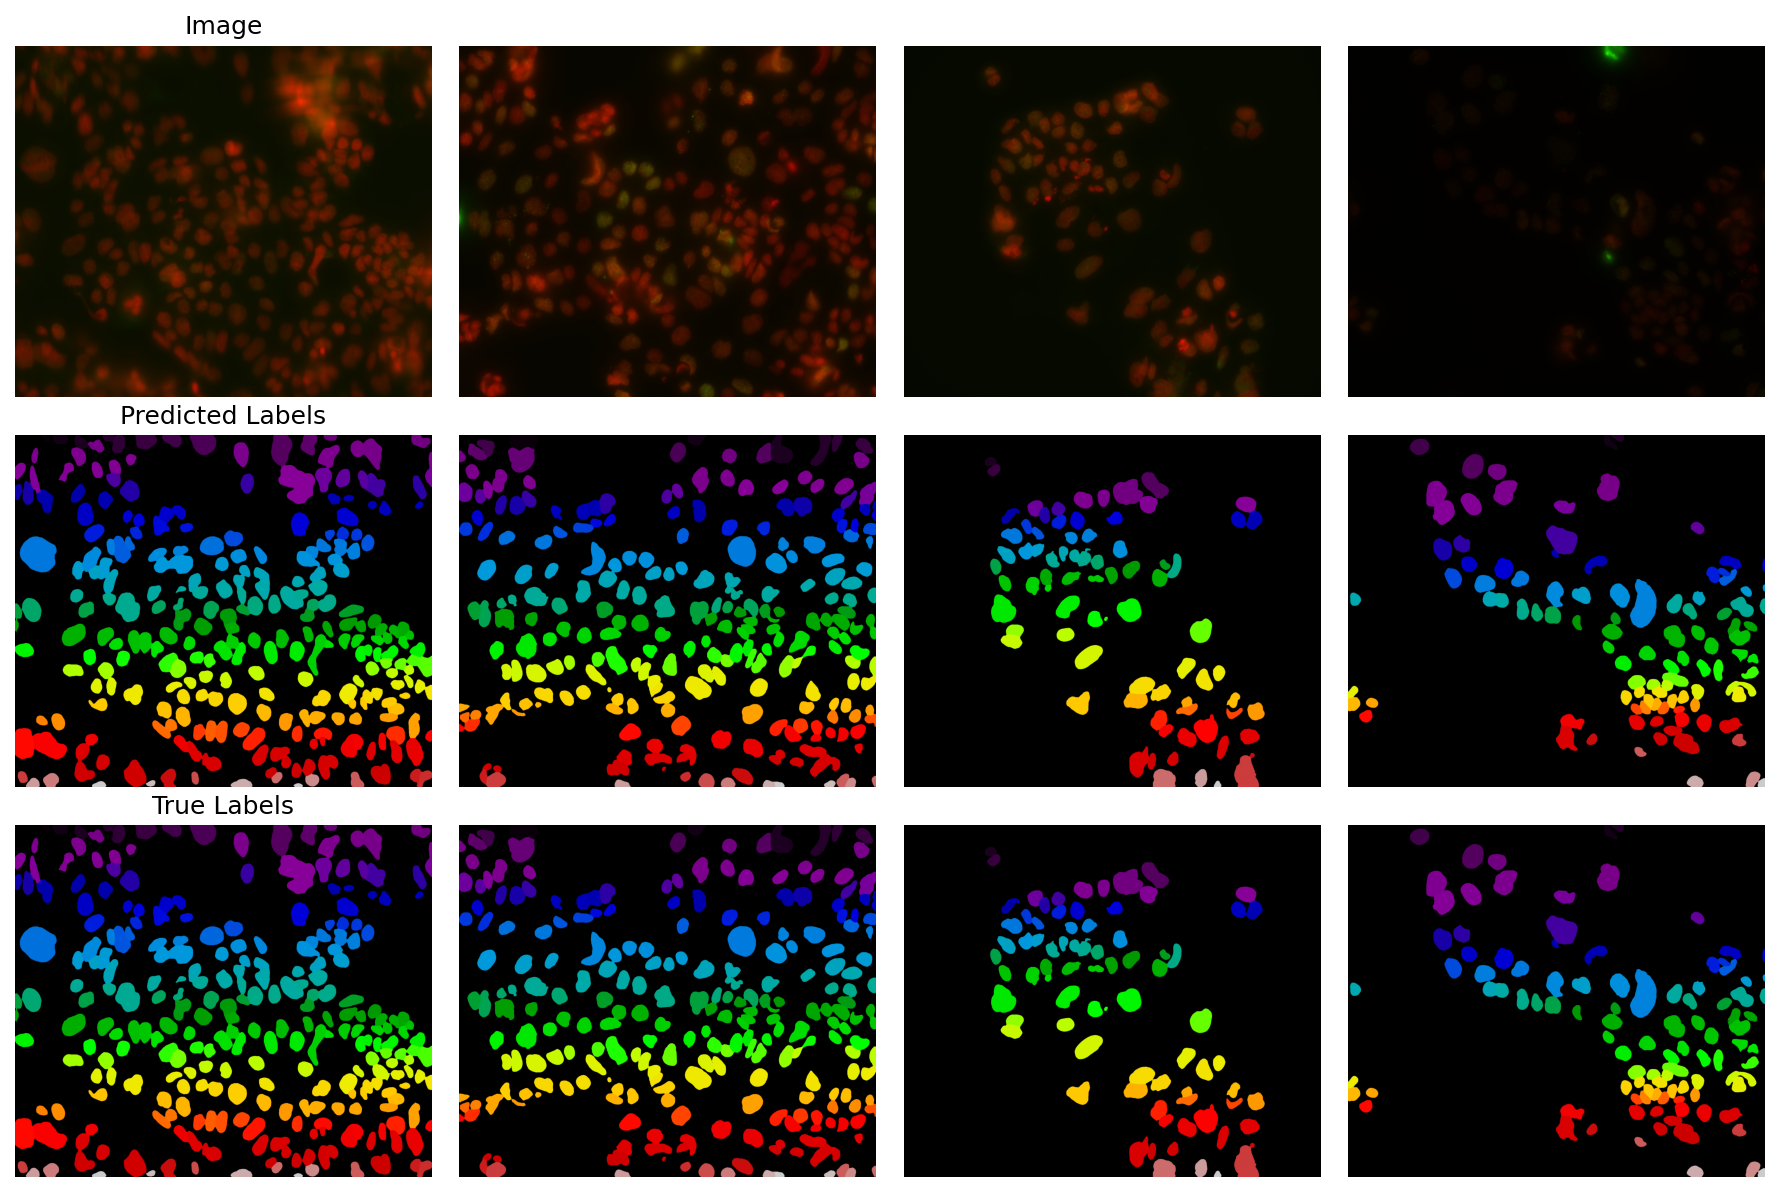

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8), dpi=150)

for k, im in enumerate(test_data):
    # Copy image and normalize if needed
    img = im.copy()
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # Normalize to [0,1]

    # Optional padding (can remove if unnecessary)
    img = np.vstack((img, np.zeros_like(img)[:1]))

    # Transpose if in (C, H, W) format
    if img.ndim == 3 and img.shape[0] <= 4:
        img = img.transpose(1, 2, 0)

    # Plot original image
    plt.subplot(3, len(test_data), k + 1)
    plt.imshow(img)
    plt.axis('off')
    if k == 0:
        plt.title('Image')

    # Plot predicted mask
    plt.subplot(3, len(test_data), len(test_data) + k + 1)
    plt.imshow(masks[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('Predicted Labels')

    # Plot ground truth
    plt.subplot(3, len(test_data), 2 * len(test_data) + k + 1)
    plt.imshow(test_labels[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()


# Use custom model to segment images

In [72]:
model_path = "custom_models/models/ddq_model_1/models/ddq_model_1"
image_dir = "test" 

# Channel Parameters:

Channel_to_use_for_segmentation = "Red" # ["Grayscale", "Blue", "Green", "Red"]
Second_segmentation_channel= "None" # ["None", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

# Segmentation parameters:
# diameter of cells (set to zero to use diameter from training set):
diameter =  0 # {type:"number"}

# threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 # {type:"slider", min:0.0, max:3.0, step:0.1}

# threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 # {type:"slider", min:-6, max:6, step:1}

In [25]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {image_dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

python -m cellpose --use_gpu --verbose --dir dataset/create_new_labels --pretrained_model custom_models/models/ddq_model_1 --chan 1 --chan2 0 --diameter 0 --flow_threshold 0.4 --cellprob_threshold 0


## run custom model

In [73]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(image_dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['test/4Gy_53BP1_8Hr.tif', 'test/4Gy_gH2AX_8Hr.tif', 'test/8Gy_53BP1_8Hr.tif', 'test/8Gy_gH2AX_8Hr.tif']
2025-09-30 14:32:20,938 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 14:32:20,939 [INFO] >>>> using GPU (CUDA)
2025-09-30 14:32:20,939 [INFO] >>>> using GPU (CUDA)
2025-09-30 14:32:20,963 [INFO] >>>> loading model custom_models/models/ddq_model_1/models/ddq_model_1
2025-09-30 14:32:20,963 [INFO] >>>> loading model custom_models/models/ddq_model_1/models/ddq_model_1
2025-09-30 14:32:20,988 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 14:32:20,988 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 14:32:20,990 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-09-30 14:32:20,988 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 14:32:20,988 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 14:32:28,534 [INFO] 

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [74]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [75]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

In [76]:
files[3]

'test/8Gy_gH2AX_8Hr.tif'

(-0.5, 3599.5, 899.5, -0.5)

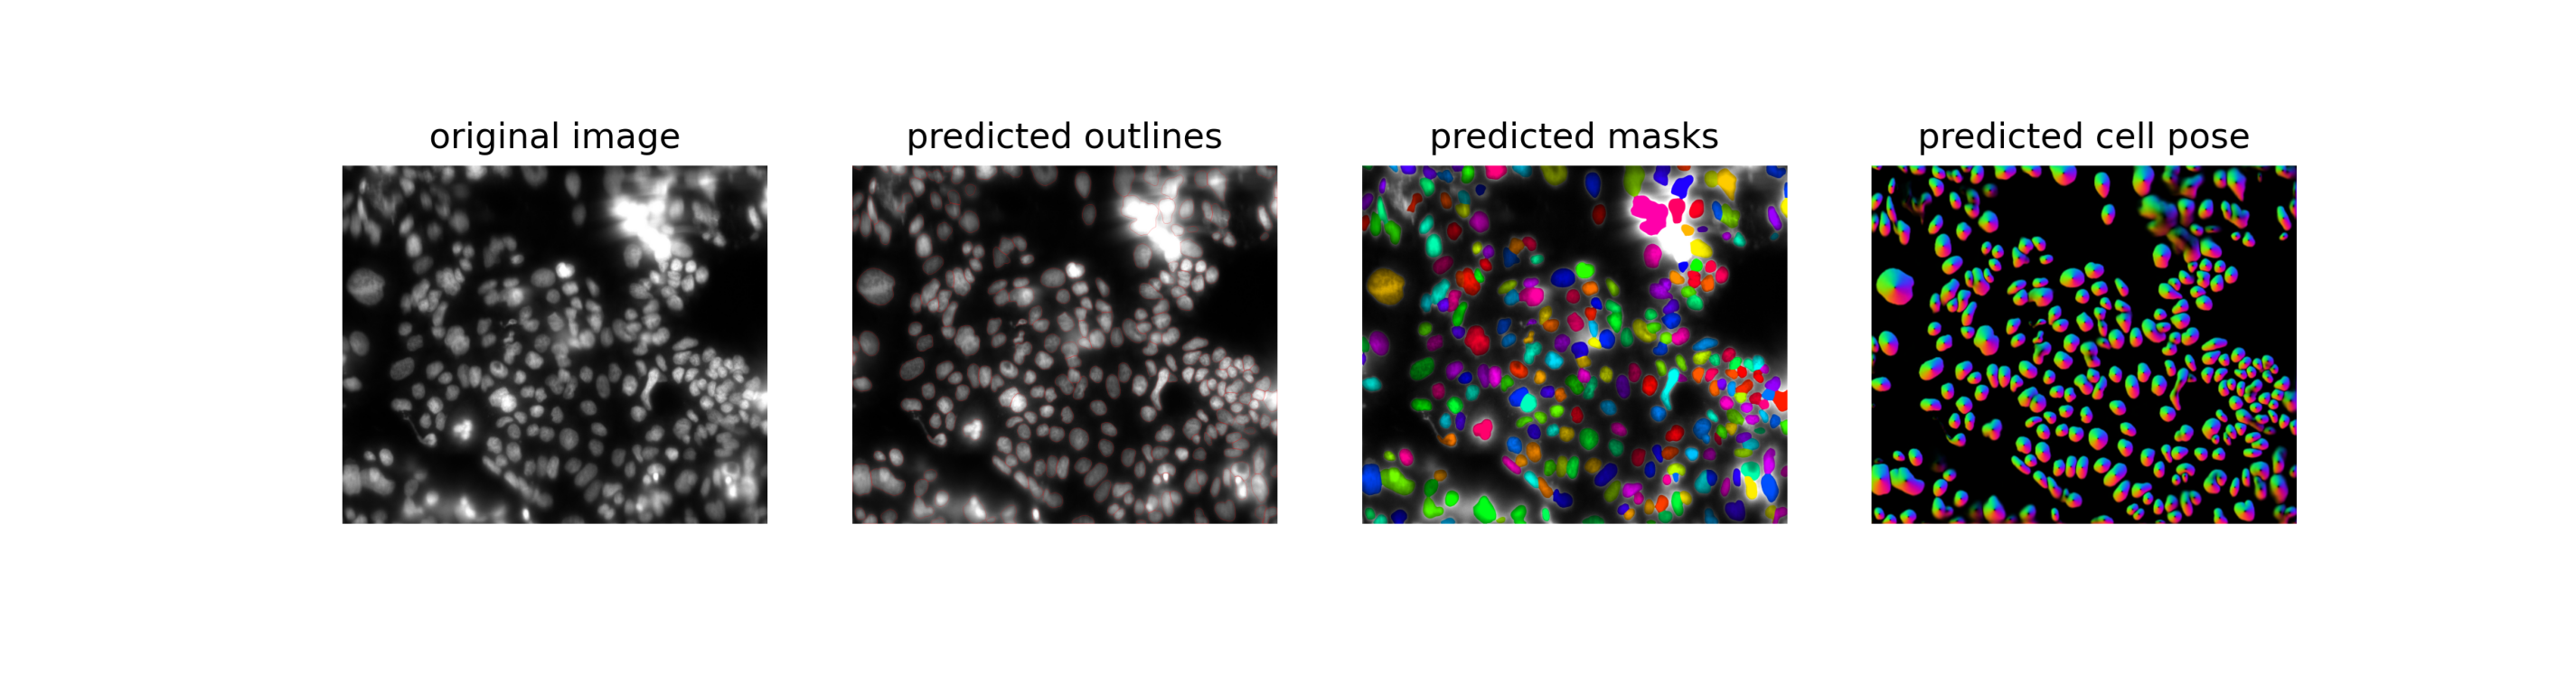

In [77]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output_cp_masks.png'))
plt.axis('off')

In [79]:
# Load test image
test_img_path = 'test/4Gy_53BP1_8Hr.tif'
test_image = io.imread(test_img_path)

print(f"Test image: {test_img_path}")
print(f"Image shape: {test_image.shape}")

# 1. Run original pre-trained nuclei model with CORRECTED parameters
print("\n=== Running Original Nuclei Model (CORRECTED) ===")
original_model = models.CellposeModel(gpu=True, model_type='nuclei')

# Fix the main issues: diameter mismatch and optimize parameters for DDQ images
original_masks, original_flows, original_styles = original_model.eval([test_image],
                                                                     channels=[chan, chan2],  # Keep same channels as custom model
                                                                     diameter=85.0,  # Use diameter matching your cell size (not default 17)
                                                                     flow_threshold=0.4,  # Keep same as custom model
                                                                     cellprob_threshold=0)  # Keep same as custom model

print(f"Original model - Cells detected: {len(np.unique(original_masks[0])) - 1}")
print(f"  └─ Parameters: diameter=85, channels=[{chan},{chan2}], flow_thresh=0.4, cellprob_thresh=0")

# 2. Run your custom trained model  
print("\n=== Running Custom Trained Model ===")
custom_model = models.CellposeModel(gpu=True, pretrained_model="custom_models/models/ddq_model_1/models/ddq_model_1")

custom_masks, custom_flows, custom_styles = custom_model.eval([test_image],
                                                              channels=[chan, chan2],
                                                              diameter=None,  # Use model's trained diameter (85.0)
                                                              flow_threshold=0.4,
                                                              cellprob_threshold=0)

print(f"Custom model - Cells detected: {len(np.unique(custom_masks[0])) - 1}")
print(f"  └─ Parameters: diameter=model_default({custom_model.diam_labels:.1f}), channels=[{chan},{chan2}]")

# Store results for visualization
original_result = original_masks[0]
custom_result = custom_masks[0]

# Performance comparison
print(f"\n=== CORRECTED COMPARISON ===")
original_count = len(np.unique(original_result)) - 1
custom_count = len(np.unique(custom_result)) - 1
difference = custom_count - original_count

print(f"Original nuclei model (corrected): {original_count} cells")
print(f"Custom DDQ model:                   {custom_count} cells")
print(f"Difference:                        {difference:+d} cells")

if abs(difference) <= 20:  # Close performance
    print("✅ Both models perform similarly with corrected parameters!")
elif custom_count > original_count:
    print("🎯 Custom model still detects more cells (better for DDQ)")
else:
    print("⚠️  Original model detects more (might be over-segmenting)")

Test image: test/4Gy_53BP1_8Hr.tif
Image shape: (2, 2160, 2560)

=== Running Original Nuclei Model (CORRECTED) ===
2025-09-30 14:34:23,716 [INFO] >> nuclei << model set to be used


2025-09-30 14:34:23,727 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 14:34:23,727 [INFO] >>>> using GPU (CUDA)
2025-09-30 14:34:23,727 [INFO] >>>> using GPU (CUDA)
2025-09-30 14:34:23,751 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 14:34:23,751 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 14:34:23,776 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 14:34:23,776 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
Original model - Cells detected: 250
  └─ Parameters: diameter=85, channels=[1,0], flow_thresh=0.4, cellprob_thresh=0

=== Running Custom Trained Model ===
2025-09-30 14:34:26,375 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 14:34:26,375 [INFO] >>>> using GPU (CUDA)
Original model - Cells detected: 250
  └─ Parameters: diameter=85, channels=[1,0], flow_thresh=0.4, cellprob_thresh=0

=== Running 

# Model Comparison Visualization

Compare the performance of trained model vs original Cellpose vs ground truth with nuclei counts for each test image.

In [ ]:
# Comprehensive 3-way model comparison for all test images
import numpy as np
import os

print("🔬 COMPREHENSIVE MODEL COMPARISON FOR ALL TEST IMAGES")
print("=" * 80)

# Get all test images (exclude _cp_masks.tif files)
all_tif_files = natsorted(glob('test/*.tif'))
test_images_paths = [f for f in all_tif_files if not f.endswith('_cp_masks.tif')]
print(f"Found {len(test_images_paths)} test images to process (excluding {len(all_tif_files) - len(test_images_paths)} _cp_masks.tif files)")

# Initialize models
print("\n🔄 Initializing models...")
original_model = models.CellposeModel(gpu=True, model_type='nuclei')
custom_model = models.CellposeModel(gpu=True, pretrained_model="custom_models/models/ddq_model_1/models/ddq_model_1")

# Process each test image
results_summary = []

for idx, test_img_path in enumerate(test_images_paths):
    print(f"\n📊 Processing {idx+1}/{len(test_images_paths)}: {os.path.basename(test_img_path)}")
    
    # Load test image
    test_image = io.imread(test_img_path)
    img_basename = os.path.splitext(os.path.basename(test_img_path))[0]
    
    # Load ground truth (correct format: {image_name}_seg.npy)
    ground_truth_path = f'test/{img_basename}_seg.npy'
    if os.path.exists(ground_truth_path):
        gt_data = np.load(ground_truth_path, allow_pickle=True).item()
        ground_truth_masks = gt_data['masks']
        gt_count = len(np.unique(ground_truth_masks)) - 1
        print(f"   ✅ Ground truth loaded: {gt_count} cells")
    else:
        print(f"   ❌ Ground truth not found: {ground_truth_path}")
        # Check what files actually exist
        available_files = [f for f in os.listdir('test') if f.endswith('_seg.npy')]
        print(f"   Available _seg.npy files: {available_files}")
        continue
    
    # Run original Cellpose model
    print("   🔄 Running original Cellpose model...")
    original_masks, _, _ = original_model.eval([test_image],
                                              channels=[chan, chan2],
                                              diameter=85.0,
                                              flow_threshold=0.4,
                                              cellprob_threshold=0)
    original_result = original_masks[0]
    original_count = len(np.unique(original_result)) - 1
    
    # Run custom trained model
    print("   🎯 Running custom trained model...")
    custom_masks, _, _ = custom_model.eval([test_image],
                                          channels=[chan, chan2],
                                          diameter=None,
                                          flow_threshold=0.4,
                                          cellprob_threshold=0)
    custom_result = custom_masks[0]
    custom_count = len(np.unique(custom_result)) - 1
    
    # Calculate accuracy for this image
    original_accuracy = 100 - abs(original_count - gt_count) / gt_count * 100 if gt_count > 0 else 0
    custom_accuracy = 100 - abs(custom_count - gt_count) / gt_count * 100 if gt_count > 0 else 0
    
    # Determine winner for this image
    if custom_accuracy > original_accuracy:
        winner = "🎯 Custom Model"
    elif original_accuracy > custom_accuracy:
        winner = "🔵 Original Model"
    else:
        winner = "🤝 Tie"
    
    # Store results
    result = {
        'image': img_basename,
        'ground_truth': gt_count,
        'original_cellpose': original_count,
        'custom_trained': custom_count,
        'original_vs_gt': original_count - gt_count,
        'custom_vs_gt': custom_count - gt_count,
        'custom_vs_original': custom_count - original_count,
        'original_accuracy': original_accuracy,
        'custom_accuracy': custom_accuracy
    }
    results_summary.append(result)
    
    print(f"   📈 Results: GT={gt_count}, Original={original_count} ({original_accuracy:.1f}%), Custom={custom_count} ({custom_accuracy:.1f}%)")
    print(f"   🏆 Winner: {winner}")

# Overall summary
print("\n" + "=" * 80)
print("📊 OVERALL PERFORMANCE SUMMARY")
print("=" * 80)

# Calculate overall statistics
total_gt = sum(r['ground_truth'] for r in results_summary)
total_orig = sum(r['original_cellpose'] for r in results_summary)
total_custom = sum(r['custom_trained'] for r in results_summary)

print(f"Images processed: {len(results_summary)}")
print(f"Total nuclei counts:")
print(f"  Ground Truth:     {total_gt:4d}")
print(f"  Original Cellpose: {total_orig:4d} ({total_orig - total_gt:+4d})")
print(f"  Custom Trained:   {total_custom:4d} ({total_custom - total_gt:+4d})")

# Overall accuracy
overall_orig_accuracy = 100 - abs(total_orig - total_gt) / total_gt * 100
overall_custom_accuracy = 100 - abs(total_custom - total_gt) / total_gt * 100

print(f"\nOverall Accuracy vs Ground Truth:")
print(f"  Original Cellpose: {overall_orig_accuracy:.1f}%")
print(f"  Custom Trained:   {overall_custom_accuracy:.1f}%")
print(f"  Improvement:      {overall_custom_accuracy - overall_orig_accuracy:+.1f}%")

# Count wins
custom_wins = sum(1 for r in results_summary if r['custom_accuracy'] > r['original_accuracy'])
original_wins = sum(1 for r in results_summary if r['original_accuracy'] > r['custom_accuracy'])
ties = len(results_summary) - custom_wins - original_wins

print(f"\nImage-by-Image Performance:")
print(f"  🎯 Custom Model wins:    {custom_wins}/{len(results_summary)} images")
print(f"  🔵 Original Model wins:  {original_wins}/{len(results_summary)} images")
print(f"  🤝 Ties:                 {ties}/{len(results_summary)} images")

# Detailed results table
print(f"\n📋 DETAILED RESULTS:")
print(f"{'Image':<20} {'GT':>4} {'Orig':>4} {'Custom':>6} {'Orig vs GT':>10} {'Custom vs GT':>12} {'Accuracy Orig':>13} {'Accuracy Custom':>15}")
print("-" * 100)

for r in results_summary:
    print(f"{r['image']:<20} {r['ground_truth']:>4} {r['original_cellpose']:>4} {r['custom_trained']:>6} "
          f"{r['original_vs_gt']:>+10} {r['custom_vs_gt']:>+12} {r['original_accuracy']:>12.1f}% {r['custom_accuracy']:>14.1f}%")

print("=" * 80)

🔬 COMPREHENSIVE MODEL COMPARISON FOR ALL TEST IMAGES
Found 8 test images to process

🔄 Initializing models...
2025-09-30 17:08:38,668 [INFO] >> nuclei << model set to be used
2025-09-30 17:08:38,678 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 17:08:38,678 [INFO] >>>> using GPU (CUDA)
2025-09-30 17:08:38,678 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 17:08:38,678 [INFO] >>>> using GPU (CUDA)
2025-09-30 17:08:38,702 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 17:08:38,702 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 17:08:38,727 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 17:08:38,727 [WARNING] pretrained_model path does not exist, using default model
2025-09-30 17:08:38,728 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 17:08:38,728 [INFO] >>>> using GPU (CUDA)
2025-09-30 17:08:38,727 [INFO] >>>> model diam_m

In [43]:
# Analyze nuclei counts in ground truth files
print("🔬 GROUND TRUTH NUCLEI ANALYSIS")
print("=" * 60)

import os
import numpy as np
from glob import glob

# Get all ground truth files
gt_files = natsorted(glob('test/*_seg.npy'))

if not gt_files:
    print(" No ground truth _seg.npy files found in test folder!")
else:
    print(f"Found {len(gt_files)} ground truth files:")
    print()
    
    total_nuclei = 0
    file_data = []
    
    for i, gt_file in enumerate(gt_files, 1):
        try:
            # Load ground truth data
            gt_data = np.load(gt_file, allow_pickle=True).item()
            masks = gt_data['masks']
            
            # Count unique objects (excluding background=0)
            unique_labels = np.unique(masks)
            nuclei_count = len(unique_labels) - 1  # Subtract 1 for background
            
            # Get image basename
            basename = os.path.basename(gt_file).replace('_seg.npy', '')
            
            file_data.append({
                'file': basename,
                'count': nuclei_count,
                'shape': masks.shape
            })
            
            total_nuclei += nuclei_count
            
            print(f"{i:2d}. {basename:<25} -> {nuclei_count:3d} nuclei (shape: {masks.shape})")
            
        except Exception as e:
            print(f"{i:2d}. {os.path.basename(gt_file):<25} -> ❌ Error: {str(e)}")

 

🔬 GROUND TRUTH NUCLEI ANALYSIS
Found 4 ground truth files:

 1. 4Gy_53BP1_8Hr             -> 267 nuclei (shape: (2160, 2560))
 2. 4Gy_gH2AX_8Hr             -> 245 nuclei (shape: (2160, 2560))
 3. 8Gy_53BP1_8Hr             ->  80 nuclei (shape: (2160, 2560))
 4. 8Gy_gH2AX_8Hr             -> 104 nuclei (shape: (2160, 2560))
 4. 8Gy_gH2AX_8Hr             -> 104 nuclei (shape: (2160, 2560))


2025-09-30 13:09:03,227 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 13:09:03,228 [INFO] >>>> using GPU (CUDA)
2025-09-30 13:09:03,228 [INFO] >>>> using GPU (CUDA)
2025-09-30 13:09:03,252 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 13:09:03,252 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 13:09:03,276 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 13:09:03,276 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 13:09:03,276 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 13:09:03,276 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
Detected 245 nuclei
Detected 245 nuclei


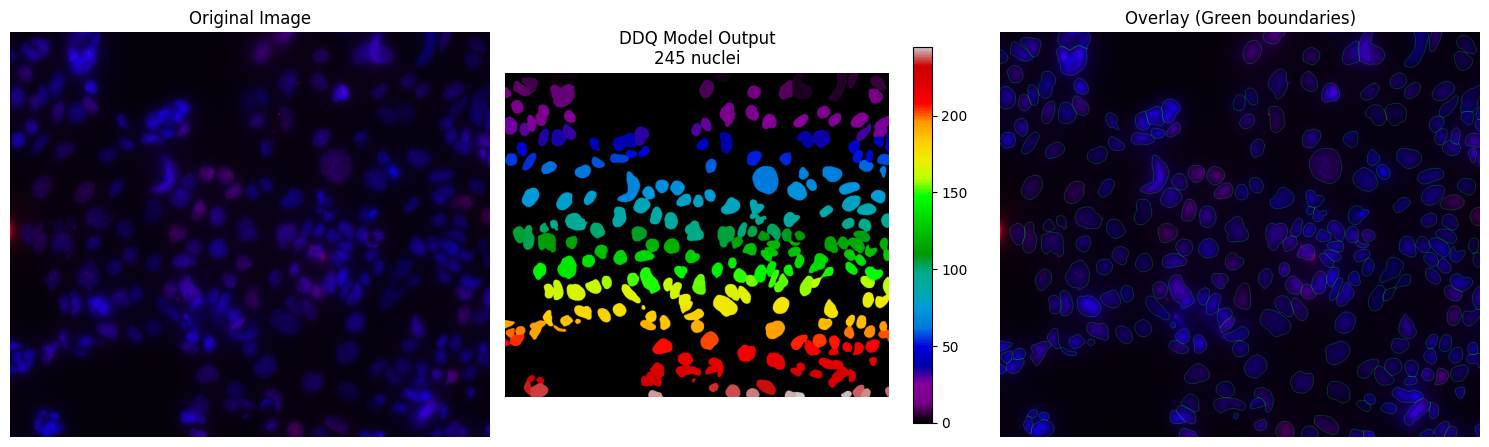

In [48]:
# Simple DDQ Model Run on 4Gy_gH2AX_8Hr.tif
import matplotlib.pyplot as plt
import numpy as np
from cellpose import io, models

# Load image and run DDQ model
test_image = io.imread('test/4Gy_gH2AX_8Hr.tif')
ddq_model = models.CellposeModel(gpu=True, pretrained_model="custom_models/models/ddq_model_1")

# Run segmentation
masks, flows, styles = ddq_model.eval([test_image], channels=[chan, chan2], diameter=None)
predicted_mask = masks[0]
nuclei_count = len(np.unique(predicted_mask)) - 1

print(f"Detected {nuclei_count} nuclei")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image (channel composite)
if test_image.ndim == 3:
    rgb_img = np.zeros((test_image.shape[1], test_image.shape[2], 3), dtype=np.uint8)
    rgb_img[:, :, 2] = (test_image[0] / test_image[0].max() * 255).astype(np.uint8)  # Blue: nuclei
    rgb_img[:, :, 0] = (test_image[1] / test_image[1].max() * 255).astype(np.uint8)  # Red: γH2AX
    axes[0].imshow(rgb_img)
else:
    axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted mask
im = axes[1].imshow(predicted_mask, cmap='nipy_spectral')
axes[1].set_title(f'DDQ Model Output\n{nuclei_count} nuclei')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], shrink=0.8)

# Overlay
if test_image.ndim == 3:
    overlay = rgb_img.copy()
    from skimage.segmentation import find_boundaries
    boundaries = find_boundaries(predicted_mask, mode='inner')
    overlay[boundaries] = [0, 255, 0]  # Green boundaries
    axes[2].imshow(overlay)
else:
    axes[2].imshow(test_image, cmap='gray')
axes[2].set_title('Overlay (Green boundaries)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Loaded: test/4Gy_gH2AX_8Hr_cp_masks.tif
Mask shape: (2160, 2560)
Nuclei detected: 245
Value range: 0 - 245


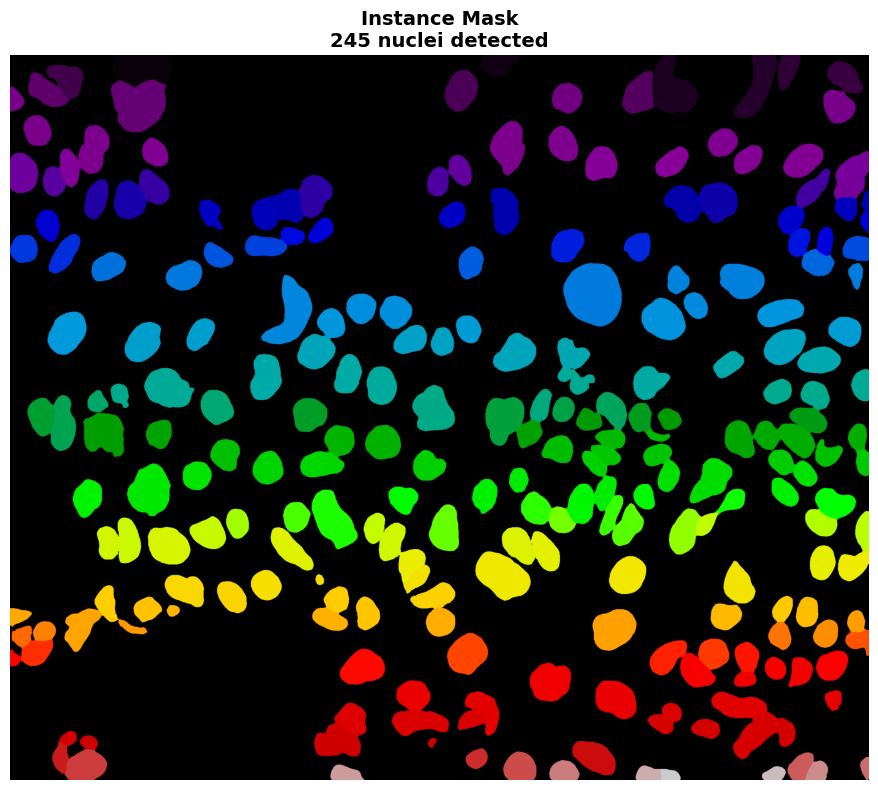

In [52]:
# Display Generated Instance Mask from cp_masks.tif
import matplotlib.pyplot as plt
import numpy as np
from cellpose import io
import os

# Load the generated cp_masks.tif file
mask_file = 'test/4Gy_gH2AX_8Hr_cp_masks.tif'

if os.path.exists(mask_file):
    # Load the instance mask
    instance_mask = io.imread(mask_file)
    nuclei_count = len(np.unique(instance_mask)) - 1  # Exclude background
    
    print(f"Loaded: {mask_file}")
    print(f"Mask shape: {instance_mask.shape}")
    print(f"Nuclei detected: {nuclei_count}")
    print(f"Value range: {instance_mask.min()} - {instance_mask.max()}")
    
    # Display the instance mask
    plt.figure(figsize=(10, 8))
    
    # Method 1: Standard colormap visualization
    im = plt.imshow(instance_mask, cmap='nipy_spectral')
    plt.title(f'Instance Mask\n{nuclei_count} nuclei detected', fontweight='bold', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"❌ File not found: {mask_file}")
    print("Available files in test folder:")
    test_files = [f for f in os.listdir('test') if 'cp_masks' in f]
    for f in test_files:
        print(f"  {f}")